In [1]:
# Cell 1: Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import SpectralClustering
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

In [3]:
# Cell 2: Load the scaled dataset
df_scaled = pd.read_csv('Data/df_scaled.csv')

# Display basic information
print(f"Dataset shape: {df_scaled.shape}")
print(f"\nFirst few rows:")
df_scaled.head()

Dataset shape: (10492, 56)

First few rows:


,Unnamed: 0,General_hearing_condition,Had_high_blood_pressure,WBC,Haemoglobin,Platelete,Age,Education_Level,Household_Size,Income_to_Poverty_Ratio,...,Race_Ethnicity_Other Hispanic,Race_Ethnicity_Other Race - Including Multi-Racial,Gender_Female,Gender_Male,Country_of_Birth_Born in 50 US states or Washington,Country_of_Birth_Unknown,Marital_Status_Married/Living with partner,Marital_Status_Never married,Marital_Status_Unknown,Marital_Status_Widowed/Divorced/Separated
0,0,1.0,1.0,-1.442156,1.285714,0.057015,-0.125,0.5,0.436829,0.915709,...,0,1,0,1,0,1,1,0,0,0
1,1,-2.0,1.0,-0.255801,0.928571,-0.524025,0.450,0.5,-0.563171,0.915709,...,0,0,0,1,1,0,1,0,0,0
2,2,-2.0,0.0,-0.667065,-0.071429,-0.299138,-0.100,-0.5,1.356915,-0.459770,...,1,0,1,0,0,1,1,0,0,0
3,3,0.0,0.0,0.061874,0.000000,0.133994,-0.125,-1.0,-0.563171,-0.758621,...,0,0,0,1,0,1,0,1,0,0
4,4,0.0,0.0,-0.126195,0.071429,-0.206814,0.425,-0.5,-0.563171,0.915709,...,0,0,1,0,1,0,1,0,0,0


In [5]:
# Cell 3: Compute affinity matrix and eigenvalues for eigengap analysis (FIXED)
from sklearn.metrics.pairwise import rbf_kernel

# Calculate gamma value using 'scale' formula manually
# gamma = 1 / (n_features * variance)
n_features = df_scaled.shape[1]
gamma_value = 1.0 / (n_features * df_scaled.var().mean())

print(f"Calculated gamma value: {gamma_value:.6f}")

# Compute affinity matrix using RBF kernel with calculated gamma
affinity_matrix = rbf_kernel(df_scaled, gamma=gamma_value)

# Compute graph Laplacian
degree_matrix = np.diag(affinity_matrix.sum(axis=1))
laplacian = degree_matrix - affinity_matrix

# Compute eigenvalues and eigenvectors
eigenvalues, eigenvectors = np.linalg.eigh(laplacian)

# Sort eigenvalues in ascending order
sorted_eigenvalues = np.sort(eigenvalues)

print(f"\nFirst 10 eigenvalues: {sorted_eigenvalues[:10]}")

Calculated gamma value: 0.000000

First 10 eigenvalues: [7.00953591e-13 9.02881812e+02 2.26078884e+03 2.68481990e+03
 2.68494380e+03 2.68581510e+03 2.68595979e+03 2.68682312e+03
 2.68697820e+03 2.68782328e+03]


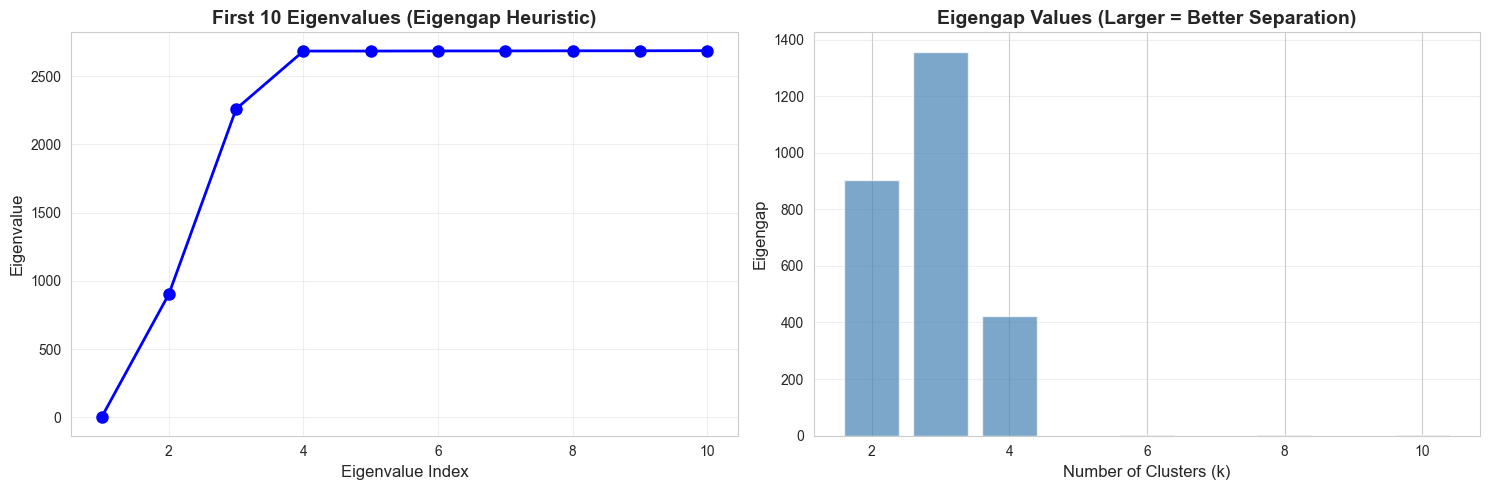


Suggested k from eigengap heuristic: 3


In [6]:
# Cell 4: Plot eigengap to identify optimal k
# Calculate eigengaps (differences between consecutive eigenvalues)
eigengaps = np.diff(sorted_eigenvalues[:15])

# Plot eigenvalues
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Eigenvalues
axes[0].plot(range(1, 11), sorted_eigenvalues[:10], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Eigenvalue Index', fontsize=12)
axes[0].set_ylabel('Eigenvalue', fontsize=12)
axes[0].set_title('First 10 Eigenvalues (Eigengap Heuristic)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

# Plot 2: Eigengaps
axes[1].bar(range(2, 11), eigengaps[:9], color='steelblue', alpha=0.7)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Eigengap', fontsize=12)
axes[1].set_title('Eigengap Values (Larger = Better Separation)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Find k with largest eigengap
optimal_k_eigengap = np.argmax(eigengaps[:6]) + 2  # +2 because eigengaps start from k=2
print(f"\nSuggested k from eigengap heuristic: {optimal_k_eigengap}")

In [7]:
# Cell 5: Perform spectral clustering for k=2 to k=7 and compute metrics
k_range = range(2, 8)
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []

print("Computing clustering metrics for k=2 to k=7...")
print("-" * 60)

for k in k_range:
    # Perform spectral clustering with calculated gamma value
    spectral = SpectralClustering(
        n_clusters=k,
        affinity='rbf',
        gamma=gamma_value,  # Use the gamma we calculated earlier
        assign_labels='kmeans',
        random_state=42,
        n_init=10
    )
    labels = spectral.fit_predict(df_scaled)
    
    # Compute metrics
    sil_score = silhouette_score(df_scaled, labels)
    db_score = davies_bouldin_score(df_scaled, labels)
    ch_score = calinski_harabasz_score(df_scaled, labels)
    
    silhouette_scores.append(sil_score)
    davies_bouldin_scores.append(db_score)
    calinski_harabasz_scores.append(ch_score)
    
    print(f"k={k} | Silhouette: {sil_score:.4f} | Davies-Bouldin: {db_score:.4f} | Calinski-Harabasz: {ch_score:.2f}")

print("-" * 60)

Computing clustering metrics for k=2 to k=7...
------------------------------------------------------------
k=2 | Silhouette: 0.6266 | Davies-Bouldin: 0.5000 | Calinski-Harabasz: 31469.50
k=3 | Silhouette: 0.5489 | Davies-Bouldin: 0.5000 | Calinski-Harabasz: 34101.50
k=4 | Silhouette: 0.5195 | Davies-Bouldin: 0.5001 | Calinski-Harabasz: 40317.59
k=5 | Silhouette: 0.5027 | Davies-Bouldin: 0.5001 | Calinski-Harabasz: 46825.40
k=6 | Silhouette: 0.4944 | Davies-Bouldin: 0.5002 | Calinski-Harabasz: 53792.52
k=7 | Silhouette: 0.4912 | Davies-Bouldin: 0.5002 | Calinski-Harabasz: 61001.33
------------------------------------------------------------


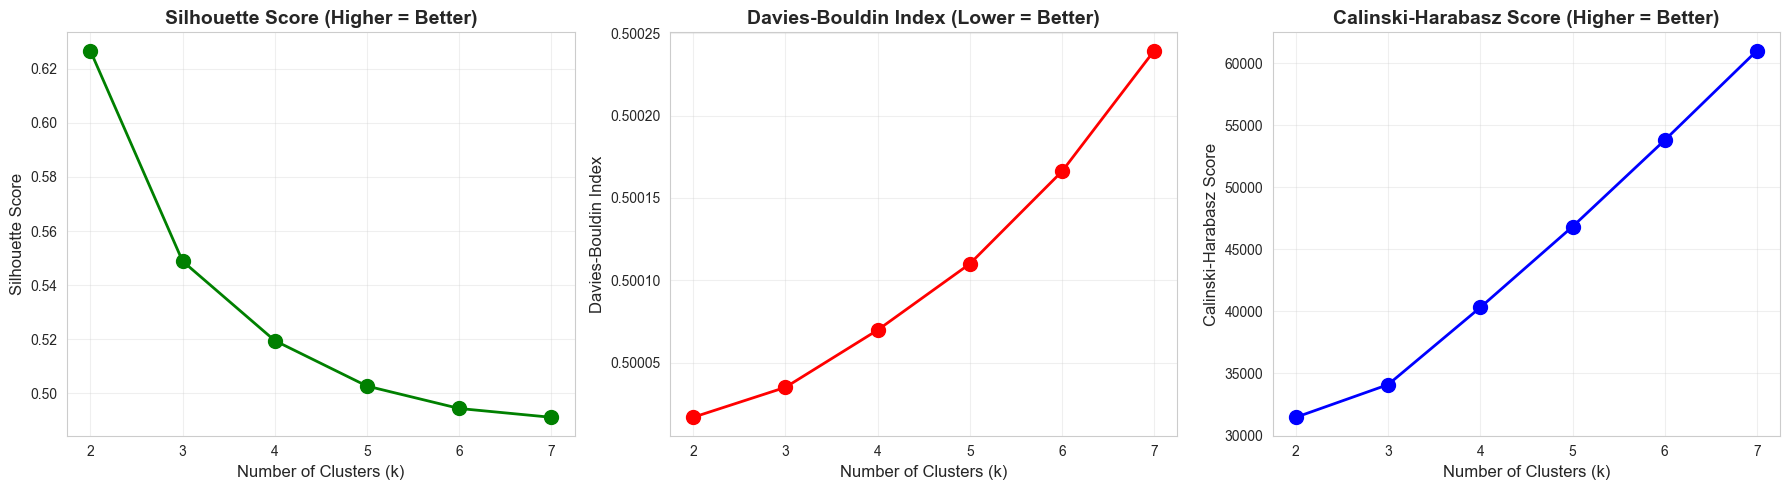


Optimal k based on different metrics:
  - Eigengap Heuristic: k=3
  - Silhouette Score: k=2
  - Davies-Bouldin Index: k=2
  - Calinski-Harabasz Score: k=7


In [8]:
# Cell 6: Visualize clustering metrics
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Silhouette Score (Higher is better)
axes[0].plot(k_range, silhouette_scores, 'go-', linewidth=2, markersize=10)
axes[0].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[0].set_ylabel('Silhouette Score', fontsize=12)
axes[0].set_title('Silhouette Score (Higher = Better)', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].set_xticks(k_range)

# Plot 2: Davies-Bouldin Index (Lower is better)
axes[1].plot(k_range, davies_bouldin_scores, 'ro-', linewidth=2, markersize=10)
axes[1].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[1].set_ylabel('Davies-Bouldin Index', fontsize=12)
axes[1].set_title('Davies-Bouldin Index (Lower = Better)', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].set_xticks(k_range)

# Plot 3: Calinski-Harabasz Score (Higher is better)
axes[2].plot(k_range, calinski_harabasz_scores, 'bo-', linewidth=2, markersize=10)
axes[2].set_xlabel('Number of Clusters (k)', fontsize=12)
axes[2].set_ylabel('Calinski-Harabasz Score', fontsize=12)
axes[2].set_title('Calinski-Harabasz Score (Higher = Better)', fontsize=14, fontweight='bold')
axes[2].grid(True, alpha=0.3)
axes[2].set_xticks(k_range)

plt.tight_layout()
plt.show()

# Identify optimal k based on each metric
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_db = k_range[np.argmin(davies_bouldin_scores)]
optimal_k_ch = k_range[np.argmax(calinski_harabasz_scores)]

print("\nOptimal k based on different metrics:")
print(f"  - Eigengap Heuristic: k={optimal_k_eigengap}")
print(f"  - Silhouette Score: k={optimal_k_silhouette}")
print(f"  - Davies-Bouldin Index: k={optimal_k_db}")
print(f"  - Calinski-Harabasz Score: k={optimal_k_ch}")

In [9]:
# Cell 7: Summary table of all metrics
metrics_df = pd.DataFrame({
    'k': list(k_range),
    'Silhouette': silhouette_scores,
    'Davies_Bouldin': davies_bouldin_scores,
    'Calinski_Harabasz': calinski_harabasz_scores
})

print("\n" + "="*70)
print("SUMMARY TABLE: Clustering Metrics for k=2 to k=7")
print("="*70)
print(metrics_df.to_string(index=False))
print("="*70)
print("\nRecommendation: Choose k based on:")
print("  1. Highest Silhouette Score")
print("  2. Lowest Davies-Bouldin Index")
print("  3. Eigengap suggestion")
print("  4. Domain knowledge (clinical interpretability)")


SUMMARY TABLE: Clustering Metrics for k=2 to k=7
 k  Silhouette  Davies_Bouldin  Calinski_Harabasz
 2    0.626647        0.500017       31469.501132
 3    0.548885        0.500035       34101.499933
 4    0.519513        0.500070       40317.587763
 5    0.502723        0.500110       46825.400626
 6    0.494442        0.500166       53792.516013
 7    0.491179        0.500239       61001.332638

Recommendation: Choose k based on:
  1. Highest Silhouette Score
  2. Lowest Davies-Bouldin Index
  3. Eigengap suggestion
  4. Domain knowledge (clinical interpretability)


In [10]:
# Cell 8: Perform spectral clustering for k=3 and k=4 to check cluster balance
print("Performing Spectral Clustering for k=3 and k=4...")
print("="*70)

# Spectral clustering with k=3
spectral_k3 = SpectralClustering(
    n_clusters=3,
    affinity='rbf',
    gamma=gamma_value,
    assign_labels='kmeans',
    random_state=42,
    n_init=10
)
labels_k3 = spectral_k3.fit_predict(df_scaled)

# Spectral clustering with k=4
spectral_k4 = SpectralClustering(
    n_clusters=4,
    affinity='rbf',
    gamma=gamma_value,
    assign_labels='kmeans',
    random_state=42,
    n_init=10
)
labels_k4 = spectral_k4.fit_predict(df_scaled)

print("\n✓ Clustering complete for both k=3 and k=4")

Performing Spectral Clustering for k=3 and k=4...

✓ Clustering complete for both k=3 and k=4


In [11]:
# Cell 9: Analyze and compare cluster balance for k=3 and k=4
import pandas as pd

# Create comparison dataframe
print("\n" + "="*70)
print("CLUSTER SIZE ANALYSIS")
print("="*70)

# k=3 analysis
print("\n--- k=3 Cluster Distribution ---")
unique_k3, counts_k3 = np.unique(labels_k3, return_counts=True)
total_samples = len(labels_k3)

for cluster, count in zip(unique_k3, counts_k3):
    percentage = (count / total_samples) * 100
    print(f"Cluster {cluster}: {count:>5} samples ({percentage:>5.2f}%)")

print(f"\nTotal: {total_samples} samples")
print(f"Largest cluster: {counts_k3.max()} ({(counts_k3.max()/total_samples)*100:.2f}%)")
print(f"Smallest cluster: {counts_k3.min()} ({(counts_k3.min()/total_samples)*100:.2f}%)")
print(f"Balance ratio (min/max): {counts_k3.min()/counts_k3.max():.3f}")

# k=4 analysis
print("\n--- k=4 Cluster Distribution ---")
unique_k4, counts_k4 = np.unique(labels_k4, return_counts=True)

for cluster, count in zip(unique_k4, counts_k4):
    percentage = (count / total_samples) * 100
    print(f"Cluster {cluster}: {count:>5} samples ({percentage:>5.2f}%)")

print(f"\nTotal: {total_samples} samples")
print(f"Largest cluster: {counts_k4.max()} ({(counts_k4.max()/total_samples)*100:.2f}%)")
print(f"Smallest cluster: {counts_k4.min()} ({(counts_k4.min()/total_samples)*100:.2f}%)")
print(f"Balance ratio (min/max): {counts_k4.min()/counts_k4.max():.3f}")

print("\n" + "="*70)
print("INTERPRETATION:")
print("- Balance ratio closer to 1.0 = more balanced clusters")
print("- Avoid clusters with <5% of data (too small for reliable patterns)")
print("- Ideal: Each cluster has 15-40% of total data")
print("="*70)


CLUSTER SIZE ANALYSIS

--- k=3 Cluster Distribution ---
Cluster 0:  4737 samples (45.15%)
Cluster 1:  2880 samples (27.45%)
Cluster 2:  2875 samples (27.40%)

Total: 10492 samples
Largest cluster: 4737 (45.15%)
Smallest cluster: 2875 (27.40%)
Balance ratio (min/max): 0.607

--- k=4 Cluster Distribution ---
Cluster 0:  1826 samples (17.40%)
Cluster 1:  1827 samples (17.41%)
Cluster 2:  3419 samples (32.59%)
Cluster 3:  3420 samples (32.60%)

Total: 10492 samples
Largest cluster: 3420 (32.60%)
Smallest cluster: 1826 (17.40%)
Balance ratio (min/max): 0.534

INTERPRETATION:
- Balance ratio closer to 1.0 = more balanced clusters
- Avoid clusters with <5% of data (too small for reliable patterns)
- Ideal: Each cluster has 15-40% of total data


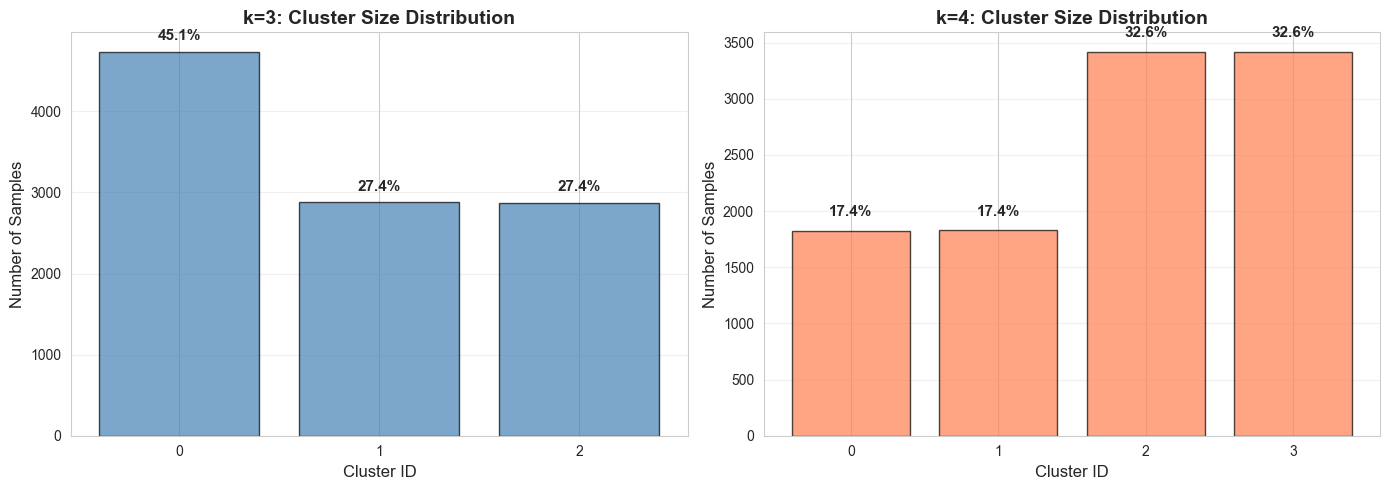


Decision Guide:
- Choose k=3 if: More balanced distribution, clearer separation
- Choose k=4 if: No cluster is <10%, want more granularity


In [13]:
# Cell 10: Visualize cluster balance comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot for k=3
axes[0].bar(unique_k3, counts_k3, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('Cluster ID', fontsize=12)
axes[0].set_ylabel('Number of Samples', fontsize=12)
axes[0].set_title('k=3: Cluster Size Distribution', fontsize=14, fontweight='bold')
axes[0].set_xticks(unique_k3)
axes[0].grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for i, (cluster, count) in enumerate(zip(unique_k3, counts_k3)):
    percentage = (count / total_samples) * 100
    axes[0].text(cluster, count + 100, f'{percentage:.1f}%', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

# Plot for k=4
axes[1].bar(unique_k4, counts_k4, color='coral', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('Cluster ID', fontsize=12)
axes[1].set_ylabel('Number of Samples', fontsize=12)
axes[1].set_title('k=4: Cluster Size Distribution', fontsize=14, fontweight='bold')
axes[1].set_xticks(unique_k4)
axes[1].grid(True, alpha=0.3, axis='y')

# Add percentage labels on bars
for i, (cluster, count) in enumerate(zip(unique_k4, counts_k4)):
    percentage = (count / total_samples) * 100
    axes[1].text(cluster, count + 100, f'{percentage:.1f}%', 
                ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\nDecision Guide:")
print("- Choose k=3 if: More balanced distribution, clearer separation")
print("- Choose k=4 if: No cluster is <10%, want more granularity")

### Okay so lets d clustering on k=4 and then sub cluster the larger clusters again into smaller clusters similar to the above approach!

In [14]:
# Cell 11: Final spectral clustering with k=4 and save results
print("="*70)
print("FINAL SPECTRAL CLUSTERING WITH k=4")
print("="*70)

# Perform spectral clustering with k=4
final_spectral = SpectralClustering(
    n_clusters=4,
    affinity='rbf',
    gamma=gamma_value,
    assign_labels='kmeans',
    random_state=42,
    n_init=10
)

# Get cluster labels
cluster_labels = final_spectral.fit_predict(df_scaled)

# Add cluster labels to the dataframe
df_scaled['Spectral_Cluster'] = cluster_labels

# Display cluster distribution
unique, counts = np.unique(cluster_labels, return_counts=True)
print("\nCluster Distribution:")
for cluster, count in zip(unique, counts):
    percentage = (count / len(cluster_labels)) * 100
    print(f"Cluster {cluster}: {count} samples ({percentage:.2f}%)")

# Save the clustered dataset
df_scaled.to_csv('Data/df_spectral_k4_clustered.csv', index=False)
print(f"\n✓ Saved clustered dataset to: Data/df_spectral_k4_clustered.csv")
print("="*70)

FINAL SPECTRAL CLUSTERING WITH k=4

Cluster Distribution:
Cluster 0: 1826 samples (17.40%)
Cluster 1: 1827 samples (17.41%)
Cluster 2: 3419 samples (32.59%)
Cluster 3: 3420 samples (32.60%)

✓ Saved clustered dataset to: Data/df_spectral_k4_clustered.csv


In [15]:
# Cell 12: Identify and extract the two largest clusters for sub-clustering
print("\n" + "="*70)
print("PREPARING DATA FOR SUB-CLUSTERING")
print("="*70)

# Get cluster sizes
cluster_sizes = pd.Series(cluster_labels).value_counts().sort_index()
print("\nCluster sizes:")
print(cluster_sizes)

# Identify the two largest clusters
largest_clusters = cluster_sizes.nlargest(2).index.tolist()
print(f"\nTwo largest clusters: {largest_clusters}")
print(f"Cluster {largest_clusters[0]}: {cluster_sizes[largest_clusters[0]]} samples")
print(f"Cluster {largest_clusters[1]}: {cluster_sizes[largest_clusters[1]]} samples")

# Extract data for each large cluster (excluding the 'Spectral_Cluster' column)
cluster_2_data = df_scaled[df_scaled['Spectral_Cluster'] == largest_clusters[0]].drop('Spectral_Cluster', axis=1)
cluster_3_data = df_scaled[df_scaled['Spectral_Cluster'] == largest_clusters[1]].drop('Spectral_Cluster', axis=1)

# Get original indices to map back later
cluster_2_indices = df_scaled[df_scaled['Spectral_Cluster'] == largest_clusters[0]].index
cluster_3_indices = df_scaled[df_scaled['Spectral_Cluster'] == largest_clusters[1]].index

print(f"\n✓ Extracted Cluster {largest_clusters[0]} data: {cluster_2_data.shape}")
print(f"✓ Extracted Cluster {largest_clusters[1]} data: {cluster_3_data.shape}")
print("="*70)


PREPARING DATA FOR SUB-CLUSTERING

Cluster sizes:
0    1826
1    1827
2    3419
3    3420
Name: count, dtype: int64

Two largest clusters: [3, 2]
Cluster 3: 3420 samples
Cluster 2: 3419 samples

✓ Extracted Cluster 3 data: (3420, 56)
✓ Extracted Cluster 2 data: (3419, 56)



EIGENGAP ANALYSIS FOR CLUSTER 3 SUB-CLUSTERING
Calculated gamma for Cluster 3: 0.000001


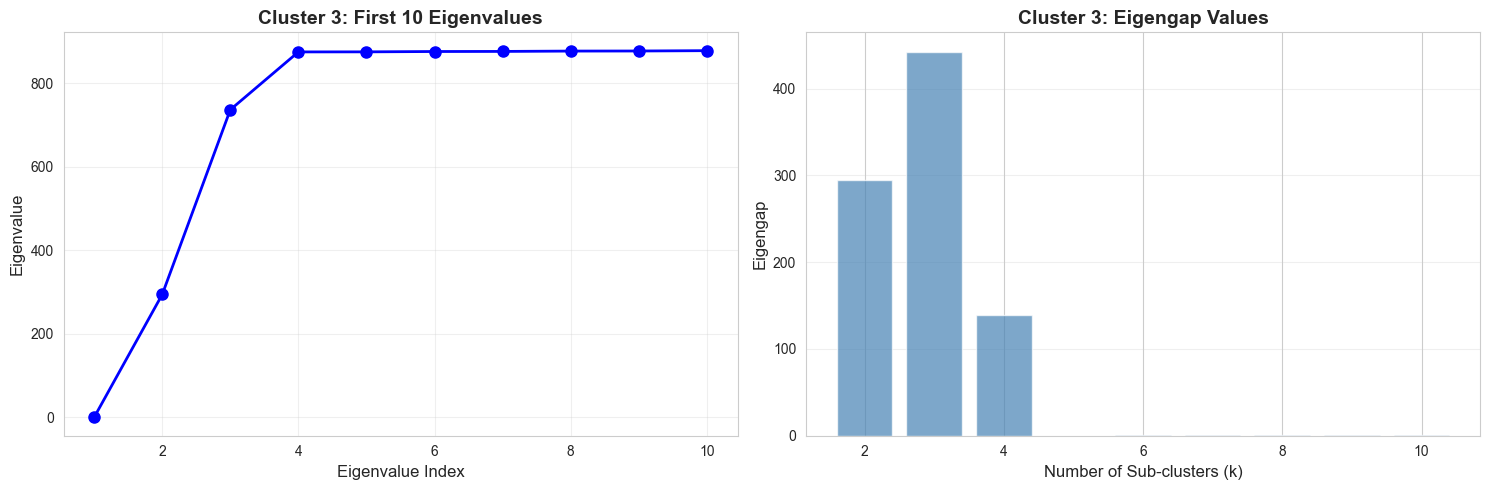


Suggested k from eigengap for Cluster 3: 3


In [16]:
# Cell 13: Eigengap analysis for Cluster 2 sub-clustering
print("\n" + "="*70)
print(f"EIGENGAP ANALYSIS FOR CLUSTER {largest_clusters[0]} SUB-CLUSTERING")
print("="*70)

# Calculate gamma for this subset
n_features_c2 = cluster_2_data.shape[1]
gamma_c2 = 1.0 / (n_features_c2 * cluster_2_data.var().mean())
print(f"Calculated gamma for Cluster {largest_clusters[0]}: {gamma_c2:.6f}")

# Compute affinity matrix
affinity_c2 = rbf_kernel(cluster_2_data, gamma=gamma_c2)

# Compute Laplacian
degree_c2 = np.diag(affinity_c2.sum(axis=1))
laplacian_c2 = degree_c2 - affinity_c2

# Eigendecomposition
eigenvalues_c2, _ = np.linalg.eigh(laplacian_c2)
sorted_eigenvalues_c2 = np.sort(eigenvalues_c2)

# Calculate eigengaps
eigengaps_c2 = np.diff(sorted_eigenvalues_c2[:10])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(1, 11), sorted_eigenvalues_c2[:10], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Eigenvalue Index', fontsize=12)
axes[0].set_ylabel('Eigenvalue', fontsize=12)
axes[0].set_title(f'Cluster {largest_clusters[0]}: First 10 Eigenvalues', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].bar(range(2, 11), eigengaps_c2[:9], color='steelblue', alpha=0.7)
axes[1].set_xlabel('Number of Sub-clusters (k)', fontsize=12)
axes[1].set_ylabel('Eigengap', fontsize=12)
axes[1].set_title(f'Cluster {largest_clusters[0]}: Eigengap Values', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Suggest k
optimal_k_c2 = np.argmax(eigengaps_c2[:5]) + 2
print(f"\nSuggested k from eigengap for Cluster {largest_clusters[0]}: {optimal_k_c2}")
print("="*70)

In [17]:
# Cell 14: Compute clustering metrics for Cluster 2 sub-clustering (k=2 to k=5)
print("\n" + "="*70)
print(f"COMPUTING METRICS FOR CLUSTER {largest_clusters[0]} SUB-CLUSTERING")
print("="*70)

k_range_c2 = range(2, 6)
sil_scores_c2 = []
db_scores_c2 = []
ch_scores_c2 = []

print(f"Testing sub-clustering for k=2 to k=5...")
print("-" * 60)

for k in k_range_c2:
    spectral_sub = SpectralClustering(
        n_clusters=k,
        affinity='rbf',
        gamma=gamma_c2,
        assign_labels='kmeans',
        random_state=42,
        n_init=10
    )
    sub_labels = spectral_sub.fit_predict(cluster_2_data)
    
    sil = silhouette_score(cluster_2_data, sub_labels)
    db = davies_bouldin_score(cluster_2_data, sub_labels)
    ch = calinski_harabasz_score(cluster_2_data, sub_labels)
    
    sil_scores_c2.append(sil)
    db_scores_c2.append(db)
    ch_scores_c2.append(ch)
    
    print(f"k={k} | Silhouette: {sil:.4f} | Davies-Bouldin: {db:.4f} | Calinski-Harabasz: {ch:.2f}")

print("-" * 60)

# Identify optimal k
optimal_k_sil_c2 = k_range_c2[np.argmax(sil_scores_c2)]
optimal_k_db_c2 = k_range_c2[np.argmin(db_scores_c2)]
optimal_k_ch_c2 = k_range_c2[np.argmax(ch_scores_c2)]

print(f"\nOptimal k for Cluster {largest_clusters[0]} sub-clustering:")
print(f"  - Eigengap: k={optimal_k_c2}")
print(f"  - Silhouette: k={optimal_k_sil_c2}")
print(f"  - Davies-Bouldin: k={optimal_k_db_c2}")
print(f"  - Calinski-Harabasz: k={optimal_k_ch_c2}")
print("="*70)


COMPUTING METRICS FOR CLUSTER 3 SUB-CLUSTERING
Testing sub-clustering for k=2 to k=5...
------------------------------------------------------------
k=2 | Silhouette: 0.6264 | Davies-Bouldin: 0.5001 | Calinski-Harabasz: 10252.61
k=3 | Silhouette: 0.5481 | Davies-Bouldin: 0.5003 | Calinski-Harabasz: 11085.98
k=4 | Silhouette: 0.5187 | Davies-Bouldin: 0.5005 | Calinski-Harabasz: 13117.90
k=5 | Silhouette: 0.5020 | Davies-Bouldin: 0.5008 | Calinski-Harabasz: 15256.24
------------------------------------------------------------

Optimal k for Cluster 3 sub-clustering:
  - Eigengap: k=3
  - Silhouette: k=2
  - Davies-Bouldin: k=2
  - Calinski-Harabasz: k=5



EIGENGAP ANALYSIS FOR CLUSTER 2 SUB-CLUSTERING
Calculated gamma for Cluster 2: 0.000001


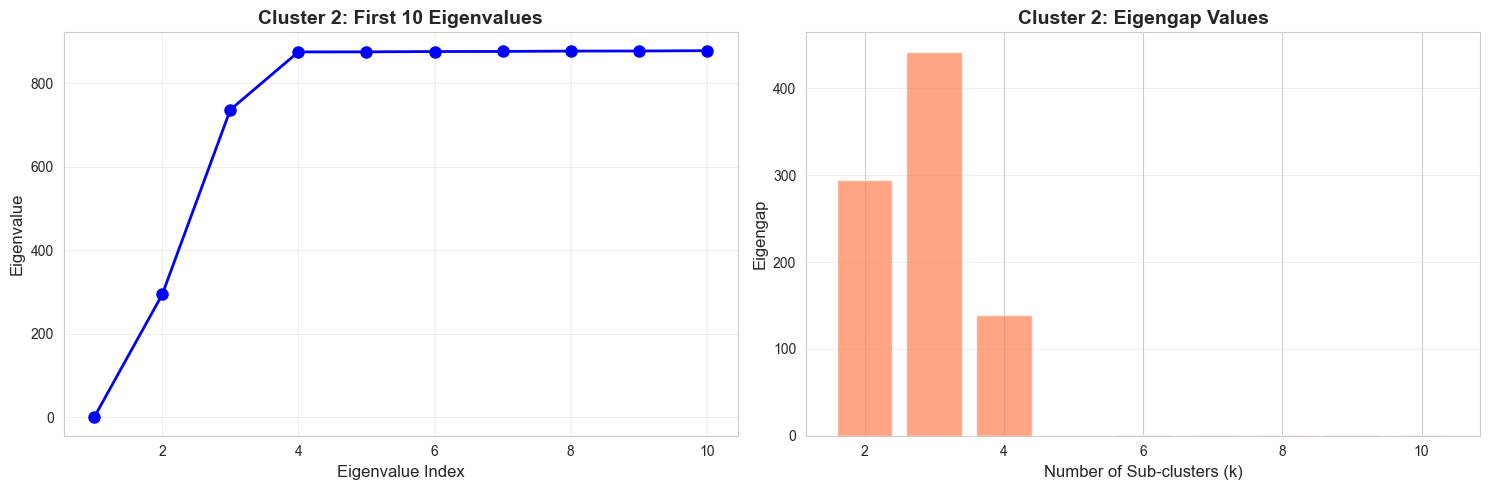


Suggested k from eigengap for Cluster 2: 3


In [18]:
# Cell 15: Eigengap analysis for Cluster 3 sub-clustering
print("\n" + "="*70)
print(f"EIGENGAP ANALYSIS FOR CLUSTER {largest_clusters[1]} SUB-CLUSTERING")
print("="*70)

# Calculate gamma for this subset
n_features_c3 = cluster_3_data.shape[1]
gamma_c3 = 1.0 / (n_features_c3 * cluster_3_data.var().mean())
print(f"Calculated gamma for Cluster {largest_clusters[1]}: {gamma_c3:.6f}")

# Compute affinity matrix
affinity_c3 = rbf_kernel(cluster_3_data, gamma=gamma_c3)

# Compute Laplacian
degree_c3 = np.diag(affinity_c3.sum(axis=1))
laplacian_c3 = degree_c3 - affinity_c3

# Eigendecomposition
eigenvalues_c3, _ = np.linalg.eigh(laplacian_c3)
sorted_eigenvalues_c3 = np.sort(eigenvalues_c3)

# Calculate eigengaps
eigengaps_c3 = np.diff(sorted_eigenvalues_c3[:10])

# Plot
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].plot(range(1, 11), sorted_eigenvalues_c3[:10], 'bo-', linewidth=2, markersize=8)
axes[0].set_xlabel('Eigenvalue Index', fontsize=12)
axes[0].set_ylabel('Eigenvalue', fontsize=12)
axes[0].set_title(f'Cluster {largest_clusters[1]}: First 10 Eigenvalues', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)

axes[1].bar(range(2, 11), eigengaps_c3[:9], color='coral', alpha=0.7)
axes[1].set_xlabel('Number of Sub-clusters (k)', fontsize=12)
axes[1].set_ylabel('Eigengap', fontsize=12)
axes[1].set_title(f'Cluster {largest_clusters[1]}: Eigengap Values', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# Suggest k
optimal_k_c3 = np.argmax(eigengaps_c3[:5]) + 2
print(f"\nSuggested k from eigengap for Cluster {largest_clusters[1]}: {optimal_k_c3}")
print("="*70)

In [19]:
# Cell 16: Compute clustering metrics for Cluster 3 sub-clustering (k=2 to k=5)
print("\n" + "="*70)
print(f"COMPUTING METRICS FOR CLUSTER {largest_clusters[1]} SUB-CLUSTERING")
print("="*70)

k_range_c3 = range(2, 6)
sil_scores_c3 = []
db_scores_c3 = []
ch_scores_c3 = []

print(f"Testing sub-clustering for k=2 to k=5...")
print("-" * 60)

for k in k_range_c3:
    spectral_sub = SpectralClustering(
        n_clusters=k,
        affinity='rbf',
        gamma=gamma_c3,
        assign_labels='kmeans',
        random_state=42,
        n_init=10
    )
    sub_labels = spectral_sub.fit_predict(cluster_3_data)
    
    sil = silhouette_score(cluster_3_data, sub_labels)
    db = davies_bouldin_score(cluster_3_data, sub_labels)
    ch = calinski_harabasz_score(cluster_3_data, sub_labels)
    
    sil_scores_c3.append(sil)
    db_scores_c3.append(db)
    ch_scores_c3.append(ch)
    
    print(f"k={k} | Silhouette: {sil:.4f} | Davies-Bouldin: {db:.4f} | Calinski-Harabasz: {ch:.2f}")

print("-" * 60)

# Identify optimal k
optimal_k_sil_c3 = k_range_c3[np.argmax(sil_scores_c3)]
optimal_k_db_c3 = k_range_c3[np.argmin(db_scores_c3)]
optimal_k_ch_c3 = k_range_c3[np.argmax(ch_scores_c3)]

print(f"\nOptimal k for Cluster {largest_clusters[1]} sub-clustering:")
print(f"  - Eigengap: k={optimal_k_c3}")
print(f"  - Silhouette: k={optimal_k_sil_c3}")
print(f"  - Davies-Bouldin: k={optimal_k_db_c3}")
print(f"  - Calinski-Harabasz: k={optimal_k_ch_c3}")
print("="*70)


COMPUTING METRICS FOR CLUSTER 2 SUB-CLUSTERING
Testing sub-clustering for k=2 to k=5...
------------------------------------------------------------
k=2 | Silhouette: 0.6264 | Davies-Bouldin: 0.5001 | Calinski-Harabasz: 10249.57
k=3 | Silhouette: 0.5486 | Davies-Bouldin: 0.5003 | Calinski-Harabasz: 11110.33
k=4 | Silhouette: 0.5188 | Davies-Bouldin: 0.5005 | Calinski-Harabasz: 13118.11
k=5 | Silhouette: 0.5022 | Davies-Bouldin: 0.5008 | Calinski-Harabasz: 15268.80
------------------------------------------------------------

Optimal k for Cluster 2 sub-clustering:
  - Eigengap: k=3
  - Silhouette: k=2
  - Davies-Bouldin: k=2
  - Calinski-Harabasz: k=5


In [20]:
# Cell 17: Perform final sub-clustering with k=3 for both large clusters
print("="*70)
print("FINAL SUB-CLUSTERING WITH k=3")
print("="*70)

# Sub-cluster Cluster 2 (the first large cluster) with k=3
spectral_sub_c2 = SpectralClustering(
    n_clusters=3,
    affinity='rbf',
    gamma=gamma_c2,
    assign_labels='kmeans',
    random_state=42,
    n_init=10
)
sub_labels_c2 = spectral_sub_c2.fit_predict(cluster_2_data)

# Sub-cluster Cluster 3 (the second large cluster) with k=3
spectral_sub_c3 = SpectralClustering(
    n_clusters=3,
    affinity='rbf',
    gamma=gamma_c3,
    assign_labels='kmeans',
    random_state=42,
    n_init=10
)
sub_labels_c3 = spectral_sub_c3.fit_predict(cluster_3_data)

print(f"\n✓ Sub-clustered Cluster {largest_clusters[0]} into 3 sub-clusters")
print(f"✓ Sub-clustered Cluster {largest_clusters[1]} into 3 sub-clusters")
print("="*70)

FINAL SUB-CLUSTERING WITH k=3

✓ Sub-clustered Cluster 3 into 3 sub-clusters
✓ Sub-clustered Cluster 2 into 3 sub-clusters


In [21]:
# Cell 18: Create continuous hierarchical cluster labels (0-7)
print("\n" + "="*70)
print("CREATING CONTINUOUS HIERARCHICAL CLUSTER LABELS")
print("="*70)

# Create a copy of the cluster labels for hierarchical mapping
hierarchical_labels = df_scaled['Spectral_Cluster'].copy()

# Map the clusters to continuous numbering
# Original Cluster 0 → stays as 0
# Original Cluster 1 → stays as 1
# Original Cluster 2 (largest_clusters[0]) → gets split into 2, 3, 4
# Original Cluster 3 (largest_clusters[1]) → gets split into 5, 6, 7

# Identify which original cluster number corresponds to which
# largest_clusters contains the two largest cluster IDs (should be 2 and 3)
cluster_2_id = largest_clusters[0]  # Should be 2
cluster_3_id = largest_clusters[1]  # Should be 3

print(f"\nMapping strategy:")
print(f"  - Original Cluster 0 → Final Cluster 0")
print(f"  - Original Cluster 1 → Final Cluster 1")
print(f"  - Original Cluster {cluster_2_id} → Final Clusters 2, 3, 4 (based on sub-clustering)")
print(f"  - Original Cluster {cluster_3_id} → Final Clusters 5, 6, 7 (based on sub-clustering)")

# Apply the mapping
for idx, sub_label in zip(cluster_2_indices, sub_labels_c2):
    hierarchical_labels.loc[idx] = 2 + sub_label  # Maps to 2, 3, 4

for idx, sub_label in zip(cluster_3_indices, sub_labels_c3):
    hierarchical_labels.loc[idx] = 5 + sub_label  # Maps to 5, 6, 7

# Add to dataframe
df_scaled['Hierarchical_Cluster'] = hierarchical_labels

print("\n✓ Created continuous hierarchical cluster labels (0-7)")
print("="*70)


CREATING CONTINUOUS HIERARCHICAL CLUSTER LABELS

Mapping strategy:
  - Original Cluster 0 → Final Cluster 0
  - Original Cluster 1 → Final Cluster 1
  - Original Cluster 3 → Final Clusters 2, 3, 4 (based on sub-clustering)
  - Original Cluster 2 → Final Clusters 5, 6, 7 (based on sub-clustering)

✓ Created continuous hierarchical cluster labels (0-7)


In [22]:
# Cell 19: Analyze final hierarchical cluster distribution
print("\n" + "="*70)
print("FINAL HIERARCHICAL CLUSTER DISTRIBUTION")
print("="*70)

# Get cluster distribution
final_clusters = df_scaled['Hierarchical_Cluster'].value_counts().sort_index()
total = len(df_scaled)

print("\nFinal Cluster Distribution:")
print("-" * 70)
for cluster in range(8):
    count = final_clusters[cluster]
    percentage = (count / total) * 100
    
    # Indicate if it's a primary cluster or sub-cluster
    if cluster in [0, 1]:
        cluster_type = "Primary"
    elif cluster in [2, 3, 4]:
        cluster_type = f"Sub-cluster of original Cluster {cluster_2_id}"
    else:  # 5, 6, 7
        cluster_type = f"Sub-cluster of original Cluster {cluster_3_id}"
    
    print(f"Cluster {cluster}: {count:>5} samples ({percentage:>5.2f}%) - {cluster_type}")

print("-" * 70)
print(f"Total: {total} samples across 8 clusters")

# Calculate balance metrics
print("\n" + "="*70)
print("BALANCE ANALYSIS")
print("="*70)
print(f"Largest cluster: {final_clusters.max()} samples ({(final_clusters.max()/total)*100:.2f}%)")
print(f"Smallest cluster: {final_clusters.min()} samples ({(final_clusters.min()/total)*100:.2f}%)")
print(f"Balance ratio (min/max): {final_clusters.min()/final_clusters.max():.3f}")
print(f"Average cluster size: {final_clusters.mean():.1f} samples")
print(f"Std deviation: {final_clusters.std():.1f} samples")

# Check for very small clusters
small_threshold = total * 0.05  # 5% threshold
small_clusters = final_clusters[final_clusters < small_threshold]
if len(small_clusters) > 0:
    print(f"\n⚠️  WARNING: {len(small_clusters)} cluster(s) have <5% of data:")
    for cluster, count in small_clusters.items():
        print(f"    Cluster {cluster}: {count} samples ({(count/total)*100:.2f}%)")
else:
    print("\n✓ All clusters have ≥5% of data - good balance!")

print("="*70)


FINAL HIERARCHICAL CLUSTER DISTRIBUTION

Final Cluster Distribution:
----------------------------------------------------------------------
Cluster 0:  1826 samples (17.40%) - Primary
Cluster 1:  1827 samples (17.41%) - Primary
Cluster 2:  1546 samples (14.74%) - Sub-cluster of original Cluster 3
Cluster 3:   937 samples ( 8.93%) - Sub-cluster of original Cluster 3
Cluster 4:   937 samples ( 8.93%) - Sub-cluster of original Cluster 3
Cluster 5:  1543 samples (14.71%) - Sub-cluster of original Cluster 2
Cluster 6:   938 samples ( 8.94%) - Sub-cluster of original Cluster 2
Cluster 7:   938 samples ( 8.94%) - Sub-cluster of original Cluster 2
----------------------------------------------------------------------
Total: 10492 samples across 8 clusters

BALANCE ANALYSIS
Largest cluster: 1827 samples (17.41%)
Smallest cluster: 937 samples (8.93%)
Balance ratio (min/max): 0.513
Average cluster size: 1311.5 samples
Std deviation: 413.8 samples

✓ All clusters have ≥5% of data - good balance!


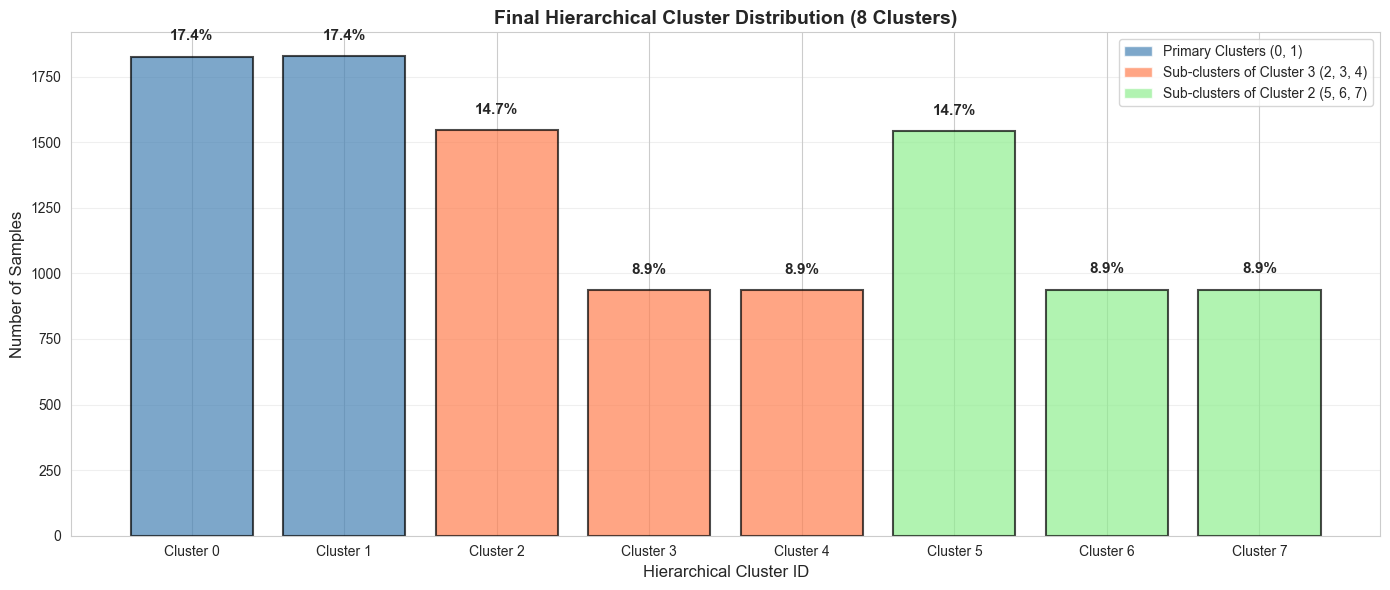


Visualization complete!


In [23]:
# Cell 20: Visualize final hierarchical cluster distribution
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

# Create color scheme: primary clusters in one color, sub-clusters in another
colors = ['steelblue', 'steelblue', 'coral', 'coral', 'coral', 'lightgreen', 'lightgreen', 'lightgreen']

# Plot bars
bars = ax.bar(range(8), [final_clusters[i] for i in range(8)], color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

# Add percentage labels on bars
for i in range(8):
    count = final_clusters[i]
    percentage = (count / total) * 100
    ax.text(i, count + 50, f'{percentage:.1f}%', ha='center', va='bottom', fontsize=11, fontweight='bold')

ax.set_xlabel('Hierarchical Cluster ID', fontsize=12)
ax.set_ylabel('Number of Samples', fontsize=12)
ax.set_title('Final Hierarchical Cluster Distribution (8 Clusters)', fontsize=14, fontweight='bold')
ax.set_xticks(range(8))
ax.set_xticklabels([f'Cluster {i}' for i in range(8)], rotation=0)
ax.grid(True, alpha=0.3, axis='y')

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='steelblue', alpha=0.7, label='Primary Clusters (0, 1)'),
    Patch(facecolor='coral', alpha=0.7, label=f'Sub-clusters of Cluster {cluster_2_id} (2, 3, 4)'),
    Patch(facecolor='lightgreen', alpha=0.7, label=f'Sub-clusters of Cluster {cluster_3_id} (5, 6, 7)')
]
ax.legend(handles=legend_elements, loc='upper right', fontsize=10)

plt.tight_layout()
plt.show()

print("\nVisualization complete!")
print("="*70)

### Okay now that we got some what balanced clusters - lets try and do some EDA on this cluster to understand what is contained inside these clusters and if they are meaningful